In [32]:
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parameter as Parameter
import time
import random
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import os
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.13.0
Torchvision Version:  0.14.0


In [33]:
folder = r'./'

net_fn = os.path.join(folder, 'binarized_net.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 50 # the original paper use batch size of 50 on CIFAR-10

In [34]:
transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [35]:
def hard_sigmoid(x):
  return torch.clamp((x+1)/2, 0, 1) # The clip function

def binarize(W, binary="stochastic"):
  if binary == "stochastic": # Stochastic binarization
    sigma = hard_sigmoid(W)
    Wb = torch.distributions.binomial.Binomial(total_count=1, probs=sigma).sample()
    Wb = torch.where(Wb==0, torch.tensor(-1., device=device), torch.tensor(1., device=device)) # If we want to binarize the network with 0 and 1, we can delete this line
  elif binary == "deterministic": 
    # Wb = torch.where(W >= 0, torch.tensor(1., device=device), torch.tensor(-1., device=device)) # Deterministic binarization with 1 and -1
    Wb = torch.where(W >= torch.mean(W), torch.tensor(1., device=device), torch.tensor(0, device=device)) # Deterministic binarization with 1 and 0
  else:
    Wb = W
  return Wb

In [36]:
class binConv2d(nn.Conv2d):
  def __init__(self, *kargs, **kwargs):
    super(binConv2d, self).__init__(*kargs, **kwargs)
  
  def forward(self, input):
    if not hasattr(self.weight, 'org'):
      self.weight.org = self.weight.data.clone()
    if True:
      self.weight.data = binarize(self.weight.org, binary="deterministic")
    else:
      self.weight.data.copy_(self.weight.org)
    output = nn.functional.conv2d(input, self.weight, None, self.stride, self.padding, self.dilation, self.groups)
    return output

class binLinear(nn.Linear):
  def __init__(self, *kargs, **kwargs):
    super(binLinear, self).__init__(*kargs, **kwargs)
    self.require_binarization = True
  
  def forward(self, input):
    if not hasattr(self.weight, 'org'):
      self.weight.org=self.weight.data.clone()
    if True:
      self.weight.data = binarize(self.weight.org, binary="deterministic")
    else:
      self.weight.data.copy_(self.weight.org)
    output = nn.functional.linear(input, self.weight, None)
    return output

In [37]:
class BinaryNet(nn.Module):
  def __init__(self):
    super(BinaryNet, self).__init__()
    self.features = nn.Sequential(
        binConv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=128, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=256, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=512, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        binConv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=1024, affine=True),
        nn.ReLU(),
        binConv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_features=1024, affine=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )
    self.classifiers = nn.Sequential(
        binLinear(4096, 1024),
        nn.BatchNorm1d(1024, affine=True),
        binLinear(1024, 10),
        nn.BatchNorm1d(10, affine=True),
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.shape[0], -1)
    x = self.classifiers(x)
    return x

In [38]:
def init_weight(layer): # https://pytorch.org/docs/stable/nn.init.html
  if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
    torch.nn.init.uniform_(layer.weight, a=0, b=1)
    # torch.nn.init.normal_(tensor=layer.weight, mean=0.5, std=1)

In [39]:
# criterion = nn.HingeEmbeddingLoss(size_average=True)
criterion = nn.CrossEntropyLoss()
num_epochs = 500
LR_start = 3 * 1e-3
LR_fin = 2 * 1e-6
LR_decay = (LR_fin/LR_start)**(1./num_epochs)
LR = LR_start
net = BinaryNet()
# net.apply(fn=init_weight) # init weight for weight of +1 and 0
print("num_epochs:", num_epochs, " learning_rate_start:", LR_start, " learning_rate_final:", LR_fin, " learning_rate_decay:", LR_decay)
print(net)
net = net.to(device)

num_epochs: 500  learning_rate_start: 0.003  learning_rate_final: 2e-06  learning_rate_decay: 0.9854800059995851
BinaryNet(
  (features): Sequential(
    (0): binConv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): binConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): binConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): binConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(k

In [40]:
def validate_model(model, dataloader, n = None):
    # Set to evaluation mode rather than training mode
    model.eval()

    top1 = 0
    total = 0

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Run the model and collect the top 1 outputs.
        # print(model.features[0].weight.data)
        outputs = model(inputs)
        # print(model.features[0].weight.data)
        _, predicted = torch.max(outputs, 1)
        # Gather statistics
        top1 += torch.sum(predicted == labels.data)
        total += len(outputs)

    top1_acc = 100 * top1.double() / total
    model.train()
    return top1_acc

In [41]:
if Path(net_fn).is_file():
  net.load_state_dict(torch.load(net_fn)) # load file if previously executed
  print("Skipped Training. Loaded network")
else:
  train_loss_of_every_epoch = []
  validation_accuracy_of_every_epoch = []

  for epoch in range(num_epochs):
    running_loss = 0.0
    running_num = 0
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)

    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = net(inputs) # forward

      loss = criterion(outputs, labels) # calculate loss.
      loss.backward() # Use binarized weights to compute derivatives to speed up.

      for p in list(net.parameters()):
        if hasattr(p,'org'):
          p.data.copy_(p.org)

      optimizer.step() # Use derivatives to update original weights rather than binarized weights.

      for p in list(net.parameters()):
        if hasattr(p,'org'):
          p.org.copy_(p.data.clamp_(0, 1))

      # for p in list(net.parameters()):
      #   p.data = p.data.clamp_(-1, 1)

      running_loss += loss.item()
      running_num += batch_size

    
    # print("eopch: ", epoch+1, ", the magnitude of gradients: ", calculate_the_magnitude_of_gradients(model=net))
      
    print("eopch: ", epoch+1, ", learning rate: ", LR)
    LR = LR * LR_decay
    
    print("eopch: ", epoch+1, ", training loss: ", running_loss / running_num)
    train_loss_of_every_epoch.append(running_loss / running_num)

    top1_acc = validate_model(net, testloader)
    print("eopch: ", epoch+1, ", accuracy: ", top1_acc)
    validation_accuracy_of_every_epoch.append(top1_acc.detach().cpu().numpy())
    
  torch.save(net.state_dict(), net_fn)
  with open(os.path.join(folder, 'train_loss_and_validation_accuracy.csv'), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(train_loss_of_every_epoch)
    writer.writerow(validation_accuracy_of_every_epoch)

  print('Finished Training. Saved network')

eopch:  1 , learning rate:  0.003
eopch:  1 , training loss:  0.04173856818437576
eopch:  1 , accuracy:  tensor(25.3500, device='cuda:0', dtype=torch.float64)
eopch:  2 , learning rate:  0.002956440017998755
eopch:  2 , training loss:  0.038030656666755674
eopch:  2 , accuracy:  tensor(30.6500, device='cuda:0', dtype=torch.float64)
eopch:  3 , learning rate:  0.0029135125266748266
eopch:  3 , training loss:  0.03466527972221375
eopch:  3 , accuracy:  tensor(39.3800, device='cuda:0', dtype=torch.float64)
eopch:  4 , learning rate:  0.0028712083422673743
eopch:  4 , training loss:  0.032334343383312224
eopch:  4 , accuracy:  tensor(40.0800, device='cuda:0', dtype=torch.float64)
eopch:  5 , learning rate:  0.0028295184143637105
eopch:  5 , training loss:  0.03131877658843994
eopch:  5 , accuracy:  tensor(42.8600, device='cuda:0', dtype=torch.float64)
eopch:  6 , learning rate:  0.002788433823963086
eopch:  6 , training loss:  0.030307278032302855
eopch:  6 , accuracy:  tensor(46.2400, dev

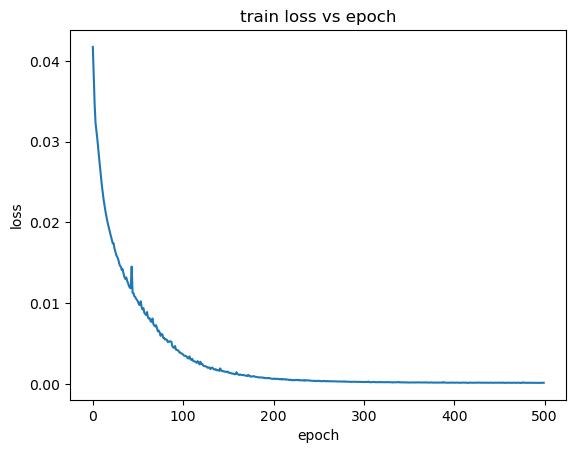

In [42]:
fig, ax = plt.subplots()
ax.plot(train_loss_of_every_epoch)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('train loss vs epoch')
fig.savefig(os.path.join(folder, 'train_loss_vs_epoch.png'))

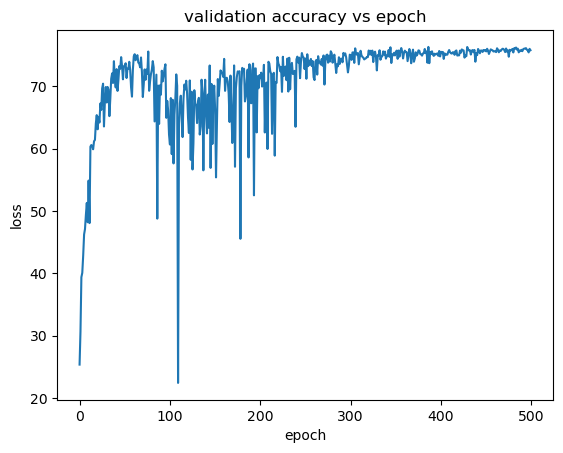

In [43]:
fig, ax = plt.subplots()
ax.plot(validation_accuracy_of_every_epoch)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('validation accuracy vs epoch')
fig.savefig(os.path.join(folder, 'validation_accuracy_vs_epoch.png'))

The next part is to train the binary network with SVHN. SVHN is quite a large dataset so the network is only trained for 30 epochs to show that our implemented network can work on multiple datasets.

In [44]:
transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset2 = torchvision.datasets.SVHN(root='./../svhn', split="train", download=True, transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset2 = torchvision.datasets.SVHN(root='./../svhn', split="test", download=True, transform=transform)
testloader2 = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
classes2 = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Using downloaded and verified file: ./../svhn\train_32x32.mat
Using downloaded and verified file: ./../svhn\test_32x32.mat


In [45]:
criterion = nn.CrossEntropyLoss()
num_epochs = 30
LR_start = 3 * 1e-3
LR_fin = 2 * 1e-6
LR_decay = (LR_fin/LR_start)**(1./500)
LR = LR_start
net2 = BinaryNet()
print("num_epochs:", num_epochs, " learning_rate_start:", LR_start, " learning_rate_final:", LR_fin, " learning_rate_decay:", LR_decay)
print(net2)
net2 = net2.to(device)

num_epochs: 30  learning_rate_start: 0.003  learning_rate_final: 2e-06  learning_rate_decay: 0.9854800059995851
BinaryNet(
  (features): Sequential(
    (0): binConv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): binConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): binConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): binConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(ke

In [46]:
train_loss_of_every_epoch = []
validation_accuracy_of_every_epoch = []

for epoch in range(num_epochs):
  running_loss = 0.0
  running_num = 0
  optimizer = torch.optim.Adam(net2.parameters(), lr=LR)

  for i, data in enumerate(trainloader2, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = net2(inputs) # forward

    loss = criterion(outputs, labels) # calculate loss.
    loss.backward() # Use binarized weights to compute derivatives to speed up.

    for p in list(net2.parameters()):
      if hasattr(p,'org'):
        p.data.copy_(p.org)

    optimizer.step() # Use derivatives to update original weights rather than binarized weights.

    for p in list(net2.parameters()):
      if hasattr(p,'org'):
        p.org.copy_(p.data.clamp_(-1,1))

    running_loss += loss.item()
    running_num += batch_size
      
  print("eopch: ", epoch+1, ", learning rate: ", LR)
  LR = LR * LR_decay
    
  print("eopch: ", epoch+1, ", training loss: ", running_loss / running_num)
  train_loss_of_every_epoch.append(running_loss / running_num)

  top1_acc = validate_model(net2, testloader2)
  print("eopch: ", epoch+1, ", accuracy: ", top1_acc)
  validation_accuracy_of_every_epoch.append(top1_acc.detach().cpu().numpy())

print('Finished Training.')

eopch:  1 , learning rate:  0.003
eopch:  1 , training loss:  0.04254852293252945
eopch:  1 , accuracy:  tensor(20.6700, device='cuda:0', dtype=torch.float64)
eopch:  2 , learning rate:  0.002956440017998755
eopch:  2 , training loss:  0.04107908182382584
eopch:  2 , accuracy:  tensor(22.6700, device='cuda:0', dtype=torch.float64)
eopch:  3 , learning rate:  0.0029135125266748266
eopch:  3 , training loss:  0.040073583796024326
eopch:  3 , accuracy:  tensor(10., device='cuda:0', dtype=torch.float64)
eopch:  4 , learning rate:  0.0028712083422673743
eopch:  4 , training loss:  0.03884127347230911
eopch:  4 , accuracy:  tensor(10., device='cuda:0', dtype=torch.float64)
eopch:  5 , learning rate:  0.0028295184143637105
eopch:  5 , training loss:  0.03717817662000656
eopch:  5 , accuracy:  tensor(10., device='cuda:0', dtype=torch.float64)
eopch:  6 , learning rate:  0.002788433823963086
eopch:  6 , training loss:  0.036220157470703125
eopch:  6 , accuracy:  tensor(10., device='cuda:0', dty